# Six Degrees of Kevin Bacon
**Introduction** - Six Degrees of Kevin Bacon is a game based on the "six degrees of separation"
concept, which posits that any two people on Earth are six or fewer acquaintance links apart. Movie
buffs challenge each other to find the shortest path between an arbitrary actor and prolific actor
Kevin Bacon. It rests on the assumption that anyone involved in the film industry can be linked
through their film roles to Bacon within six steps.
The analysis of social networks can be a computationally intensive task, especially when dealing with
large volumes of data. It is also a challenging problem to devise a correct methodology to infer an
informative social network structure. Here, we will analyze a social network of actors and actresses
that co-participated in movies. We will do some simple descriptive analysis, and in the end try to
relate an actor/actress’s position in the social network with the success of the movies in which they
participate.

#### Rules & Notes - Please take your time to read the following points:

1. The submission deadline shall be set for the 10th of June at 23:59.
2. It is acceptable that you **discuss** with your colleagues different approaches to solve each step of the problem set. You are responsible for writing your own code, and analysing the results. Clear cases of cheating will be penalized with 0 points in this assignment;
3. After review of your submission files, and before a mark is attributed, you might be called to orally defend your submission;
4. You will be scored first and foremost by the number of correct answers, secondly by the logic used in the trying to approach each step of the problem set;
5. Consider skipping questions that you are stuck in, and get back to them later;
6. Expect computations to take a few minutes to finish in some of the steps.
7. **IMPORTANT** It is expected you have developed skills beyond writting SQL queries. Any question where you directly write a SQL query (then for example create a temporary table and use spark.sql to pass the query) will receive a 25% penalty. Using the Spark syntax (for example dataframe.select("\*").where("conditions")) is acceptable and does not incur this penalty. Comment your code in a reasonable fashion.
8. **Questions** – Any questions about this assignment should be posted in the Forum@Moodle. The last class will be an open office session for anyone with questions concerning the assignment. 
9. **Delivery** - To fulfil this activity you will have to upload the following materials to Moodle:
    1. An exported IPython notebook. The notebook should be solved (have results displayed), but should contain all neccesary code so that when the notebook is run in databricks it should also replicate these results. This means the all data downloading and processing should be done in this notebook. It is also important you clearly indicate where your final answer to each question is when you are using multiple cells (for example you print "my final anwser is" before your answer or use cell comments). Please make sure to name your file in the following way: *[student_number1]_[student_number2]_submission.ipynb*. As an example: *19740001_197400010_submission.ipynb*
    2. **Delivery** - You will also need to provide a signed statement of authorship, which is present in the last page;
    3. It is recommended you read the whole assignment before starting.
    4. You can add as many cells as you like to answer the questions.
    5. You can make use of caching or persisting your RDDs or Dataframes, this may speed up performance.
    6. If you have trouble with graphframes in databricks (specifically the import statement) you need to make sure the graphframes package is installed on the cluster you are running. If you click home on the left, then click on the graphframes library, from where you can install the package on your cluster (check the graphframes checkbox and click install). Another installation option is using the JAR available on Moodle with the graphframes library.
10. **Note**: By including the name and student number of each group member  in the submission notebook, this will be considered as a declaration of authorship.

#### Data Sources and Description
We will use data from IMDB. You can download raw datafiles
from https://datasets.imdbws.com. Note that the files are tab delimited (.tsv) You can find a
description of the each datafile in https://www.imdb.com/interfaces/

## Questions
### Data loading and preperation
Review the file descriptions and load the necessary data onto your databricks cluser and into spark dataframes. You will need to use shell commands to download the data, unzip the data, load the data into spark. Note that the data might require parsing and preprocessing to be ready for the questions below.

**Hints** You can use 'gunzip' to unzip the .tz files. The data files will then be tab seperated (.tsv), which you can load into a dataframe using the tab seperated option instead of the comma seperated option we have typically used in class: `.option(“sep”,”\t”)`

In [0]:
# Import the necessary libraries and configurations
from pyspark.sql.functions import col, split, when, size, explode, collect_list, desc, collect_set, sum, avg, array_contains
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, FloatType
from pyspark.sql import SparkSession, Row

from graphframes import GraphFrame

from itertools import combinations

from collections import Counter

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import sklearn

from operator import add
from statistics import mean

#### Data Loading

In [0]:
def download_datasets(urls):
    """
    Downloads, unzips, and moves datasets from the specified URLs to the Databricks FileStore.

    Parameters:
    urls (list of str): List of URLs to download datasets from.

    Returns:
    str: A confirmation message once all datasets are processed.
    """
    for url in urls:

        # Step 1: Download the dataset using wget
        download_cmd = f"wget '{url}' -O /tmp/{url.split('/')[-1]}"
        # Execute the download command
        !{download_cmd}

        # Step 2: Unzip the dataset using gunzip
        unzip_cmd = f"gunzip -f /tmp/{url.split('/')[-1]}"
        # Execute the unzip command
        !{unzip_cmd}

        # Step 3: Move the unzipped file to the Databricks FileStore
        filename = url.split('/')[-1].replace('.gz', '')
        # Use dbutils to move the file from local tmp directory to dbfs
        dbutils.fs.cp(f"file:/tmp/{filename}", f"dbfs:/FileStore/{filename}", True)
        
    return 'done'

# Use the function to download the datasets:
urls = [
    "https://datasets.imdbws.com/name.basics.tsv.gz",      # URL for the name.basics dataset
    "https://datasets.imdbws.com/title.akas.tsv.gz",       # URL for the title.akas dataset
    "https://datasets.imdbws.com/title.basics.tsv.gz",     # URL for the title.basics dataset
    "https://datasets.imdbws.com/title.crew.tsv.gz",       # URL for the title.crew dataset
    "https://datasets.imdbws.com/title.episode.tsv.gz",    # URL for the title.episode dataset
    "https://datasets.imdbws.com/title.principals.tsv.gz", # URL for the title.principals dataset
    "https://datasets.imdbws.com/title.ratings.tsv.gz"     # URL for the title.ratings dataset
]

# Download, unzip, and move the datasets to the FileStore
download_datasets(urls)


--2024-06-10 09:19:44--  https://datasets.imdbws.com/name.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.245.253.85, 18.245.253.117, 18.245.253.55, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.245.253.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267679080 (255M) [binary/octet-stream]
Saving to: ‘/tmp/name.basics.tsv.gz’

/tmp/name.basics.ts 100%[===================>] 255.28M   299MB/s    in 0.9s    

2024-06-10 09:19:45 (299 MB/s) - ‘/tmp/name.basics.tsv.gz’ saved [267679080/267679080]

--2024-06-10 09:20:00--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.245.253.70, 18.245.253.85, 18.245.253.117, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.245.253.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420964024 (401M) [binary/octet-stream]
Saving to: ‘/tmp/title.akas.tsv.gz’

/tmp/title.akas.tsv 100%[============

'done'

In [0]:
# Verify the folder creation by listing contents of /FileStore
display(dbutils.fs.ls("/FileStore"))


path,name,size,modificationTime
dbfs:/FileStore/name.basics.tsv,name.basics.tsv,833717610,1718011194000
dbfs:/FileStore/title.akas.tsv,title.akas.tsv,2444971608,1718011219000
dbfs:/FileStore/title.basics.tsv,title.basics.tsv,932609640,1718011245000
dbfs:/FileStore/title.crew.tsv,title.crew.tsv,352572674,1718011255000
dbfs:/FileStore/title.episode.tsv,title.episode.tsv,216845162,1718011260000
dbfs:/FileStore/title.principals.tsv,title.principals.tsv,3837504795,1718011294000
dbfs:/FileStore/title.ratings.tsv,title.ratings.tsv,25085697,1718011324000


#### Name Basics

In [0]:
# Define the path to the name.basics.tsv file in the Databricks FileStore
datafile_nbasics_path = "dbfs:/FileStore/name.basics.tsv"

# Define the schema structure for the name.basics.tsv file, according to the Metadata  
schema = StructType([
    StructField("nconst", StringType(), False),            # Unique identifier for names. Cannot accept null values, since we decided that every person has to have an identification
    StructField("primaryName", StringType(), True),                   # Primary name of the person
    StructField("birthYear", IntegerType(), True),                    # Birth year of the person
    StructField("deathYear", IntegerType(), True),                    # Death year of the person
    StructField("primaryProfession", ArrayType(StringType()), True),  # Array of primary professions
    StructField("knownForTitles", ArrayType(StringType()), True)      # Array of known titles (movies/TV shows)
])

# Read the TSV file without specifying the schema
df_name_basics = spark.read.option("sep", "\t").csv(datafile_nbasics_path, header=True)

# Define the columns that need to be converted into arrays
array_columns = ["primaryProfession", "knownForTitles"]

# Convert the specified columns into arrays by splitting the string values
for col_name in array_columns:
    df_name_basics = df_name_basics.withColumn(col_name, split(col(col_name), ","))

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_name_basics = df_name_basics.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_name_basics.show(truncate=False)

+---------+-------------------+---------+---------+---------------------------------------+--------------------------------------------+
|nconst   |primaryName        |birthYear|deathYear|primaryProfession                      |knownForTitles                              |
+---------+-------------------+---------+---------+---------------------------------------+--------------------------------------------+
|nm0000001|Fred Astaire       |1899     |1987     |[actor, miscellaneous, producer]       |[tt0072308, tt0050419, tt0053137, tt0027125]|
|nm0000002|Lauren Bacall      |1924     |2014     |[actress, soundtrack, archive_footage] |[tt0037382, tt0075213, tt0117057, tt0038355]|
|nm0000003|Brigitte Bardot    |1934     |NULL     |[actress, music_department, producer]  |[tt0057345, tt0049189, tt0056404, tt0054452]|
|nm0000004|John Belushi       |1949     |1982     |[actor, writer, music_department]      |[tt0072562, tt0077975, tt0080455, tt0078723]|
|nm0000005|Ingmar Bergman     |1918     |

#### Title Akas

In [0]:
# Define the path to the title.akas.tsv file in the Databricks FileStore
datafile_akas_path = "dbfs:/FileStore/title.akas.tsv"

# Define the schema structure for the title.akas.tsv file, according to the Metadata
schema = StructType([
    StructField("titleId", StringType(), False),         # Unique identifier for titles. Cannot accept null values, since we decided that every title has to have an identification
    StructField("ordering", IntegerType(), True),             # Ordering of titles
    StructField("title", StringType(), True),                 # Title name
    StructField("region", StringType(), True),                # Region of the title
    StructField("language", StringType(), True),              # Language of the title
    StructField("types", ArrayType(StringType()), True),      # Array of types associated with the title
    StructField("attributes", ArrayType(StringType()), True), # Array of attributes associated with the title
    StructField("isOriginalTitle", IntegerType(), True)       # Flag indicating if it's the original title
])

# Read the TSV file without specifying the schema
df_title_akas = spark.read.option("sep", "\t").csv(datafile_akas_path, header=True)

# Define the columns that need to be converted into arrays
array_columns = ["types", "attributes"]

# Convert the specified columns into arrays by splitting the string values
for col_name in array_columns:
    df_title_akas = df_title_akas.withColumn(col_name, split(col(col_name), ","))

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_akas = df_title_akas.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_akas.show(truncate=False)

+---------+--------+-------------------------+------+--------+-------------+-----------------------+---------------+
|titleId  |ordering|title                    |region|language|types        |attributes             |isOriginalTitle|
+---------+--------+-------------------------+------+--------+-------------+-----------------------+---------------+
|tt0000001|1       |Carmencita               |\N    |\N      |[original]   |[\N]                   |1              |
|tt0000001|2       |Carmencita               |DE    |\N      |[\N]         |[literal title]        |0              |
|tt0000001|3       |Carmencita               |US    |\N      |[imdbDisplay]|[\N]                   |0              |
|tt0000001|4       |Carmencita - spanyol tánc|HU    |\N      |[imdbDisplay]|[\N]                   |0              |
|tt0000001|5       |Καρμενσίτα               |GR    |\N      |[imdbDisplay]|[\N]                   |0              |
|tt0000001|6       |Карменсита               |RU    |\N      |[i

#### Title Basics

In [0]:
# Define the path to the title.basics.tsv file in the Databricks FileStore
datafile_tbasics_path = "dbfs:/FileStore/title.basics.tsv"

# Define the schema structure for the title.basics.tsv file, according to the Metadata
schema = StructType([
    StructField("tconst", StringType(), False),            # Unique identifier for titles. Cannot accept null values, since we decided that every title has to have an identification
    StructField("titleType", StringType(), True),            # Type of the title (e.g., movie, short, TV series)
    StructField("primaryTitle", StringType(), True),         # Primary title of the work
    StructField("originalTitle", StringType(), True),        # Original title of the work
    StructField("isAdult", IntegerType(), True),             # Indicates if the title is adult content
    StructField("startYear", IntegerType(), True),           # Start year of the title
    StructField("endYear", IntegerType(), True),             # End year of the title (if applicable)
    StructField("runtimeMinutes", IntegerType(), True),      # Runtime in minutes
    StructField("genres", ArrayType(StringType()), True)     # Array of genres associated with the title
])

# Read the TSV file without specifying the schema
df_title_basics = spark.read.option("sep", "\t").csv(datafile_tbasics_path, header=True)

# Define the columns that need to be converted into arrays
array_columns = ["genres"]

# Convert the specified columns into arrays by splitting the string values
for col_name in array_columns:
    df_title_basics = df_title_basics.withColumn(col_name, split(col(col_name), ","))

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_basics = df_title_basics.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_basics.show(truncate=False)

+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+----------------------------+
|tconst   |titleType|primaryTitle                               |originalTitle                                    |isAdult|startYear|endYear|runtimeMinutes|genres                      |
+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+----------------------------+
|tt0000001|short    |Carmencita                                 |Carmencita                                       |0      |1894     |NULL   |1             |[Documentary, Short]        |
|tt0000002|short    |Le clown et ses chiens                     |Le clown et ses chiens                           |0      |1892     |NULL   |5             |[Animation, Short]          |
|tt0000003|short    |Pauvre Pierrot                             |Pauvr

#### Title Crew

In [0]:
# Define the path to the title.crew.tsv file in the Databricks FileStore
datafile_crew_path = "dbfs:/FileStore/title.crew.tsv"

# Define the schema structure for the title.crew.tsv file, according to the Metadata
schema = StructType([
    StructField("tconst", StringType(), False),          # Unique identifier for titles. Cannot accept null values, since we decided that every title has to have an identification
    StructField("directors", ArrayType(StringType()), True), # Array of directors associated with the title
    StructField("writers", ArrayType(StringType()), True)    # Array of writers associated with the title
])

# Read the TSV file without specifying the schema
df_title_crew = spark.read.option("sep", "\t").csv(datafile_crew_path, header=True)

# Define the columns that need to be converted into arrays
array_columns = ["directors", "writers"]

# Convert the specified columns into arrays by splitting the string values
for col_name in array_columns:
    df_title_crew = df_title_crew.withColumn(col_name, split(col(col_name), ","))

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_crew = df_title_crew.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_crew.show(truncate=False)

+---------+----------------------+-----------+
|tconst   |directors             |writers    |
+---------+----------------------+-----------+
|tt0000001|[nm0005690]           |[\N]       |
|tt0000002|[nm0721526]           |[\N]       |
|tt0000003|[nm0721526]           |[\N]       |
|tt0000004|[nm0721526]           |[\N]       |
|tt0000005|[nm0005690]           |[\N]       |
|tt0000006|[nm0005690]           |[\N]       |
|tt0000007|[nm0005690, nm0374658]|[\N]       |
|tt0000008|[nm0005690]           |[\N]       |
|tt0000009|[nm0085156]           |[nm0085156]|
|tt0000010|[nm0525910]           |[\N]       |
|tt0000011|[nm0804434]           |[\N]       |
|tt0000012|[nm0525908, nm0525910]|[\N]       |
|tt0000013|[nm0525910]           |[\N]       |
|tt0000014|[nm0525910]           |[\N]       |
|tt0000015|[nm0721526]           |[\N]       |
|tt0000016|[nm0525910]           |[\N]       |
|tt0000017|[nm1587194, nm0804434]|[\N]       |
|tt0000018|[nm0804434]           |[\N]       |
|tt0000019|[n

#### Title Episode

In [0]:
# Define the path to the title.episode.tsv file in the Databricks FileStore
datafile_episode_path = "dbfs:/FileStore/title.episode.tsv"

# Define the schema structure for the title.episode.tsv file, according to the Metadata
schema = StructType([
    StructField("tconst", StringType(), False),        # Unique identifier for episodes. Cannot accept null values, since we decided that every title has to have an identification
    StructField("parentTconst", StringType(), True),    # Unique identifier for the parent title (series)
    StructField("seasonNumber", IntegerType(), True),   # Season number of the episode
    StructField("episodeNumber", IntegerType(), True)   # Episode number within the season
])

# Read the TSV file without specifying the schema
df_title_episode = spark.read.option("sep", "\t").csv(datafile_episode_path, header=True)

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_episode = df_title_episode.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_episode.show(truncate=False)

+---------+------------+------------+-------------+
|tconst   |parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0041951|tt0041038   |1           |9            |
|tt0042816|tt0989125   |1           |17           |
|tt0042889|tt0989125   |NULL        |NULL         |
|tt0043426|tt0040051   |3           |42           |
|tt0043631|tt0989125   |2           |16           |
|tt0043693|tt0989125   |2           |8            |
|tt0043710|tt0989125   |3           |3            |
|tt0044093|tt0959862   |1           |6            |
|tt0044668|tt0044243   |2           |16           |
|tt0044901|tt0989125   |3           |46           |
|tt0045519|tt0989125   |4           |11           |
|tt0045960|tt0044284   |2           |3            |
|tt0046135|tt0989125   |4           |5            |
|tt0046150|tt0341798   |NULL        |NULL         |
|tt0046855|tt0046643   |1           |4            |
|tt0046864|tt0989125   |5           |20           |
|tt0047810|t

#### Title Principals

In [0]:
# Define the path to the title.principals.tsv file in the Databricks FileStore
datafile_principals_path = "dbfs:/FileStore/title.principals.tsv"

# Define the schema structure for the title.principals.tsv file, according to the Metadata
schema = StructType([
    StructField("tconst", StringType(), False),   # Unique identifier for titles. Cannot accept null values, since we decided that every title has to have an identification
    StructField("ordering", IntegerType(), True), # Ordering of the principal cast/crew

    # Unique identifier for names (actors/crew). Cannot accept null values, since we decided that every person has to have an identification
    StructField("nconst", StringType(), False),

    StructField("category", StringType(), True),   # Category of job (e.g., actor, director)
    StructField("job", StringType(), True),        # Specific job description
    StructField("characters", StringType(), True)  # Characters played (if applicable)
])

# Read the TSV file without specifying the schema
df_title_principals = spark.read.option("sep", "\t").csv(datafile_principals_path, header=True)

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_principals = df_title_principals.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_principals.show(truncate=False)

+---------+--------+---------+---------------+-----------------------+--------------+
|tconst   |ordering|nconst   |category       |job                    |characters    |
+---------+--------+---------+---------------+-----------------------+--------------+
|tt0000001|1       |nm1588970|self           |\N                     |["Self"]      |
|tt0000001|2       |nm0005690|director       |\N                     |\N            |
|tt0000001|3       |nm0005690|producer       |producer               |\N            |
|tt0000001|4       |nm0374658|cinematographer|director of photography|\N            |
|tt0000002|1       |nm0721526|director       |\N                     |\N            |
|tt0000002|2       |nm1335271|composer       |\N                     |\N            |
|tt0000003|1       |nm0721526|director       |\N                     |\N            |
|tt0000003|2       |nm1770680|producer       |producer               |\N            |
|tt0000003|3       |nm0721526|producer       |producer

#### Title Ratings

In [0]:
# Define the path to the title.ratings.tsv file in the Databricks FileStore
datafile_ratings_path = "dbfs:/FileStore/title.ratings.tsv"

# Define the schema structure for the title.ratings.tsv file, according to the Metadata
schema = StructType([
    StructField("tconst", StringType(), False),        # Unique identifier for titles. Cannot accept null values, since we decided that every title has to have an identification
    StructField("averageRating", FloatType(), True),   # Average rating of the title
    StructField("numVotes", IntegerType(), True)       # Number of votes the title received
])

# Read the TSV file without specifying the schema
df_title_ratings = spark.read.option("sep", "\t").csv(datafile_ratings_path, header=True)

# Apply the defined schema to the DataFrame by casting each column to the specified data type
for field in schema.fields:
    df_title_ratings = df_title_ratings.withColumn(field.name, col(field.name).cast(field.dataType))

# Show the DataFrame with all columns without truncating the content
df_title_ratings.show(truncate=False)

+---------+-------------+--------+
|tconst   |averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|5.7          |2059    |
|tt0000002|5.6          |277     |
|tt0000003|6.5          |2020    |
|tt0000004|5.3          |180     |
|tt0000005|6.2          |2787    |
|tt0000006|5.1          |187     |
|tt0000007|5.4          |872     |
|tt0000008|5.4          |2202    |
|tt0000009|5.4          |212     |
|tt0000010|6.8          |7590    |
|tt0000011|5.2          |389     |
|tt0000012|7.4          |12922   |
|tt0000013|5.7          |1971    |
|tt0000014|7.1          |5870    |
|tt0000015|6.1          |1183    |
|tt0000016|5.9          |1584    |
|tt0000017|4.6          |348     |
|tt0000018|5.2          |629     |
|tt0000019|5.1          |32      |
|tt0000020|4.7          |383     |
+---------+-------------+--------+
only showing top 20 rows



#### Handling Missing Values

In [0]:
def replace_nulls(*dfs):
    """
    Replace '\\N' with None (null) in all columns and treat empty lists ['\\N'] as None for array columns in the given DataFrames.
    
    Parameters:
    *dfs (pyspark.sql.DataFrame): Variable number of DataFrames to process.
    
    Returns:
    tuple: A tuple of updated DataFrames.
    """
    updated_dfs = []
    
    for df in dfs:

        # Replace '\N' with None (null) in all columns of the DataFrame
        df = df.replace(r'\N', None)
        
        # Loop through each field in the DataFrame schema
        for field in df.schema.fields:

            # Check if the field is an array of strings
            if isinstance(field.dataType, ArrayType) and field.dataType.elementType == StringType():
               
                # Replace array columns containing a single '\\N' with None
                df = df.withColumn(field.name, when(size(col(field.name)) == 1, None).otherwise(col(field.name)))
        
        # Append the updated DataFrame to the list
        updated_dfs.append(df)
    
    return tuple(updated_dfs)

# Apply the function to the DataFrames inplace
df_name_basics, df_title_akas, df_title_basics, df_title_crew, df_title_episode, df_title_principals, df_title_ratings = replace_nulls(
    df_name_basics, df_title_akas, df_title_basics, df_title_crew, df_title_episode, df_title_principals, df_title_ratings
)

# Show the updated DataFrames to verify the changes
for df in [df_name_basics, df_title_akas, df_title_basics, df_title_crew, df_title_episode, df_title_principals, df_title_ratings]:
    df.show(truncate=False)

+---------+-------------------+---------+---------+---------------------------------------+--------------------------------------------+
|nconst   |primaryName        |birthYear|deathYear|primaryProfession                      |knownForTitles                              |
+---------+-------------------+---------+---------+---------------------------------------+--------------------------------------------+
|nm0000001|Fred Astaire       |1899     |1987     |[actor, miscellaneous, producer]       |[tt0072308, tt0050419, tt0053137, tt0027125]|
|nm0000002|Lauren Bacall      |1924     |2014     |[actress, soundtrack, archive_footage] |[tt0037382, tt0075213, tt0117057, tt0038355]|
|nm0000003|Brigitte Bardot    |1934     |NULL     |[actress, music_department, producer]  |[tt0057345, tt0049189, tt0056404, tt0054452]|
|nm0000004|John Belushi       |1949     |1982     |[actor, writer, music_department]      |[tt0072562, tt0077975, tt0080455, tt0078723]|
|nm0000005|Ingmar Bergman     |1918     |

### Network Inference, Let’s build a network
In the following questions you will look to summarise the data and build a network. We want to examine a network that abstracts how actors and actress are related through their co-participation in movies. To that end perform the following steps:

**Q1** Create a DataFrame that combines **all the information** on each of the titles (i.e., movies, tv-shows, etc …) and **all of the information** the participants in those movies (i.e., actors, directors, etc … ), make sure the actual names of the movies and participants are included. It may be worth reviewing the following questions to see how this dataframe will be used.

How many rows does your dataframe have?

**Note:**

Although there are 7 Data Frames available (Name Basics, Title Basics, Title Akas, Title Crew, Title Episode, Title Ratings, and Title Principals), we have opted to focus solely on combining the relevant information from the Title Principals, Title Ratings, and Title Basics Data Frames for titles (movies). Additionally, we are incorporating participant information exclusively from the Name Basics Data Frame. This decision is based on our analysis of the subsequent questions, which indicate that the other Data Frames are not necessary for our purposes.

In [0]:
# Step 1: Join title_principals with name_basics to get participant details
q1_df = df_title_principals.join(df_name_basics, on="nconst", how="inner")

# Step 2: Join the resulting DataFrame with title_basics to get title details
q1_df = q1_df.join(df_title_basics, on="tconst", how="inner")

# Step 3: Join with title_ratings to get ratings information for every title
q1_df = q1_df.join(df_title_ratings, on="tconst", how="inner")

# Count the number of rows in the final DataFrame
number_of_rows = q1_df.count()

# Show the first 10 rows of the final DataFrame to verify the success of the join operations
q1_df.show(10, truncate=False)

+---------+---------+--------+---------------+--------+--------------------------------------------------+--------------------+---------+---------+----------------------------------------------+--------------------------------------------+---------+----------------------+------------------------+-------+---------+-------+--------------+------------------+-------------+--------+
|tconst   |nconst   |ordering|category       |job     |characters                                        |primaryName         |birthYear|deathYear|primaryProfession                             |knownForTitles                              |titleType|primaryTitle          |originalTitle           |isAdult|startYear|endYear|runtimeMinutes|genres            |averageRating|numVotes|
+---------+---------+--------+---------------+--------+--------------------------------------------------+--------------------+---------+---------+----------------------------------------------+--------------------------------------------

In [0]:
# Display the number of rows, to answer Q1
print(f"The Data Frame has: {number_of_rows} rows")

The Data Frame has: 20097755 rows


**Q2** Create a new DataFrame based on the previous step, with the following removed:
1. Any participant that is not an actor or actress (as measured by the category column);
1. All adult movies;
1. All dead actors or actresses;
1. All actors or actresses born before 1920 or with no date of birth listed;
1. All titles that are not of the type movie.

How many rows does your dataframe have?

In [0]:
# Step 1: Remove any participant that is not an actor or actress
q2_df = q1_df.filter((col("category") == "actor") | (col("category") == "actress"))

# Step 2: Remove all adult movies
q2_df = q2_df.filter(col("isAdult") == 0)

# Step 3: Remove all dead actors or actresses
q2_df = q2_df.filter(col("deathYear").isNull())

# Step 4: Remove all actors or actresses born before 1920 or with no date of birth listed
q2_df = q2_df.filter((col("birthYear").isNotNull()) & (col("birthYear") >= 1920))

# Step 5: Remove all titles that are not of the type movie
q2_df = q2_df.filter(col("titleType") == "movie")

# Count the number of rows in the final DataFrame
number_of_rows_filtered = q2_df.count()

# Show the first 10 rows of the filtered DataFrame to verify
q2_df.show(10, truncate=False)

+---------+---------+--------+--------+----+----------------------------------+----------------+---------+---------+-----------------------------------------+--------------------------------------------+---------+-----------------------------+-----------------------------+-------+---------+-------+--------------+-------------------------+-------------+--------+
|tconst   |nconst   |ordering|category|job |characters                        |primaryName     |birthYear|deathYear|primaryProfession                        |knownForTitles                              |titleType|primaryTitle                 |originalTitle                |isAdult|startYear|endYear|runtimeMinutes|genres                   |averageRating|numVotes|
+---------+---------+--------+--------+----+----------------------------------+----------------+---------+---------+-----------------------------------------+--------------------------------------------+---------+-----------------------------+-----------------------------

In [0]:
# Display the number of rows, to answer Q2
print(f"The Data Frame has {number_of_rows_filtered} rows")

The Data Frame has 749253 rows


**Q3** Convert the above Dataframe to an RDD. Use map and reduce to create a paired RDD which counts how many movies each actor / actress appears in.

Display names of the top 10 actors/actresses according to the number of movies in which they appeared. Be careful to deal with different actors / actresses with the same name, these could be different people.

In [0]:
# Select the columns of interest (nconst and primaryName) from Q2 and convert it to an RDD
q3_rdd = q2_df.select("nconst", "primaryName").rdd

# Create a paired RDD where the key is the actor/actress' nconst (to avoid potential situations of different actors/actresses having the same name being considered the same people) and the value is 1
q3_rdd = q3_rdd.map(lambda row: (row["nconst"], 1))

# Use reduceByKey to count the number of movies for each actor/actress
q3_rdd = q3_rdd.reduceByKey(lambda a, b: a + b)

# Join the counts with the actor/actress names
names_rdd = q2_df.select("nconst", "primaryName").rdd.distinct().map(lambda row: (row["nconst"], row["primaryName"]))
q3_rdd = q3_rdd.join(names_rdd)

# Swap the key-value pairs to sort by the number of movies each actor/actress appears in
q3_rdd_output = q3_rdd.map(lambda x: (x[1][0], x[1][1])).sortByKey(ascending=False)

# Take the top 10 actors/actresses by movie appearances
top_10_actors = q3_rdd_output.take(10)

# Display the top 10 actors/actresses by movie appearances
for count, name in top_10_actors:
    print(f"{name}: appeared in {count} movies")

Brahmanandam: appeared in 798 movies
Jagathy Sreekumar: appeared in 514 movies
Shakti Kapoor: appeared in 476 movies
Mammootty: appeared in 411 movies
Mohanlal: appeared in 378 movies
Mithun Chakraborty: appeared in 370 movies
Aruna Irani: appeared in 368 movies
Anupam Kher: appeared in 365 movies
Nassar: appeared in 365 movies
Tanikella Bharani: appeared in 365 movies


**Q4** Start with the dataframe from Q2. Generate a DataFrame that lists all links of your network. Here we shall consider that a link connects a pair of actors/actresses if they participated in at least one movie together (actors / actresses should be represented by their unique ID's). For every link we then need anytime a pair of actors were together in a movie as a link in each direction (A -> B and B -> A). However links should be distinct we do not need duplicates when two actors worked together in several movies. 

Display a DataFrame with the first 10 edges.

In [0]:
# Function to create pairs of actors
def create_pairs(actors):
    """
    Create pairs of actors who acted in the same movie.
    
    Args:
    actors (list): List of actors in a movie.
    
    Returns:
    list: List of tuples containing pairs of actors in both directions.
    """
    pairs = []
    sorted_actors = sorted(actors)  # Sort actors to ensure consistent ordering and to avoid duplicates, for example (A, B) and (B, A)
    n = len(sorted_actors)
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((sorted_actors[i], sorted_actors[j]))  # Add pair (A, B) and (B, A)
    return pairs

# Register the UDF (User Defined Function)
create_pairs_udf = udf(create_pairs, ArrayType(ArrayType(StringType())))

# Step 1: Group by tconst (movie identification) and collect the list of nconst (actor identification)
actors_grouped = q2_df.groupBy("tconst").agg(collect_list("nconst").alias("actors"))

# Step 2: Apply the UDF to create pairs of actors for each movie and explode the resulting pairs
pairs_df = actors_grouped.withColumn("pairs", explode(create_pairs_udf(col("actors"))))

# Step 3: Select the individual pairs and ensure each pair is unique
q4_df = pairs_df.select(
    col("pairs").getItem(0).alias("actor1"),  # Select the first actor in the pair
    col("pairs").getItem(1).alias("actor2")   # Select the second actor in the pair
).distinct()  # Ensure each pair is unique

# Step 4: Join with q2_df DataFrame to get primaryName for actor1
q4_df = q4_df.join(
    q2_df.select("nconst", "primaryName").distinct(),                    # Select distinct nconst and primaryName from q2_df
    q4_df.actor1 == q2_df.nconst,                                        # Join condition: actor1 in q4_df matches nconst in q2_df
    "left"                                                               # Left join to keep all actor1 even if there's no match in q2_df
).withColumnRenamed("primaryName", "Actor 1 Name").drop("nconst")        # Rename the primaryName column to "Actor 1 Name"
                                                                         # Drop the nconst column to avoid ambiguity in subsequent joins

# Step 5: Join with q2_df DataFrame to get primaryName for actor2
q4_df = q4_df.join(
    q2_df.select("nconst", "primaryName").distinct(),                    # Select distinct nconst and primaryName from q2_df
    q4_df.actor2 == q2_df.nconst,                                        # Join condition: actor2 in q4_df matches nconst in q2_df
    "left"                                                               # Left join to keep all actor2 even if there's no match in q2_df
).withColumnRenamed("primaryName", "Actor 2 Name").drop("nconst")        # Rename the primaryName column to "Actor 2 Name"
                                                                         # Drop the nconst column to avoid ambiguity

# Step 6: Display the first 10 edges with actor names
q4_df.select("actor1", "Actor 1 Name", "actor2", "Actor 2 Name").show(10, truncate=False)

+---------+------------------+---------+------------------+
|actor1   |Actor 1 Name      |actor2   |Actor 2 Name      |
+---------+------------------+---------+------------------+
|nm0279524|Gregor Fisher     |nm0517642|Phyllis Logan     |
|nm0517642|Phyllis Logan     |nm0561155|Giovanni Mauriello|
|nm0279524|Gregor Fisher     |nm0561155|Giovanni Mauriello|
|nm0177320|Tommy Cook        |nm0571763|Harry McKim       |
|nm0517642|Phyllis Logan     |nm0949942|Paul Young        |
|nm0561155|Giovanni Mauriello|nm0949942|Paul Young        |
|nm0279524|Gregor Fisher     |nm0949942|Paul Young        |
|nm0149883|Fay Chaldecott    |nm0172237|Cora Sue Collins  |
|nm0063929|Rene Beard        |nm0418152|Eilene Janssen    |
|nm0177320|Tommy Cook        |nm0824222|Bob Stebbins      |
+---------+------------------+---------+------------------+
only showing top 10 rows



**Q5** Compute the page rank of each actor. This can be done using GraphFrames or
by using RDDs and the iterative implementation of the PageRank algorithm. Do not take
more than 5 iterations and use reset probility = 0.1.

List the top 10 actors / actresses by pagerank.

In [0]:
# Create a DataFrame for vertices with distinct actor IDs
actor_ids = q4_df.select(col("actor1").alias("id")).union(q4_df.select(col("actor2").alias("id"))).distinct()

# Create a DataFrame for edges
edges = q4_df.select(col("actor1").alias("src"), col("actor2").alias("dst"))

# Create a GraphFrame from the vertices and edges
graph = GraphFrame(actor_ids, edges)

# Compute PageRank using GraphFrames, keeping at maximum 5 iterations and a reset probability of 0.1
results = graph.pageRank(resetProbability=0.1, maxIter=5)

# Get all actors/actresses' PageRank and order by the PageRank from the highest to lowest
q5_df = results.vertices.orderBy("pagerank", ascending=False)

# Join with the Q2 DataFrame to show the actors/actresses' names   
q5_df_with_names = q5_df.join(q2_df.select("nconst", "primaryName").distinct(), q5_df.id == q2_df.nconst, "left") \
                        .select("id", "primaryName", "pagerank") \
                        .orderBy("pagerank", ascending=False)

# Display the top 10 actors/actresses by PageRank with their names
q5_df_with_names.show(10, truncate=False)

+---------+----------------+------------------+
|id       |primaryName     |pagerank          |
+---------+----------------+------------------+
|nm0000616|Eric Roberts    |48.71990343037742 |
|nm0000514|Michael Madsen  |30.008493679902248|
|nm0001803|Danny Trejo     |22.23336086939524 |
|nm0202966|Keith David     |21.45265045274668 |
|nm0261724|Joe Estevez     |20.79757260482764 |
|nm0000448|Lance Henriksen |20.6681468318118  |
|nm0000532|Malcolm McDowell|20.19561624739266 |
|nm0001595|Michael Paré    |19.973561116547785|
|nm0726223|Richard Riehle  |19.112720789082935|
|nm0000367|Gérard Depardieu|18.67106559026893 |
+---------+----------------+------------------+
only showing top 10 rows



**Q6**: Create an RDD with the number of outDegrees for each actor. Display the top 10 by outdegrees.

In [0]:
# Calculate outDegrees for each actor/actress
outdegrees = graph.outDegrees

# Convert to an RDD
q6_rdd = outdegrees.rdd

# Convert the RDD back to a DataFrame for printing purposes
q6_df = q6_rdd.toDF(["id", "outDegree"])

# Join with the Q2 DataFrame to get the actor/actresses' names
q6_df_with_names = q6_df.join(q2_df.select("nconst", "primaryName").distinct(), q6_df.id == q2_df.nconst, "left") \
                        .select("id", "primaryName", "outDegree") \
                        .orderBy(col("outDegree").desc())

# Display the top 10 actors/actresses by outDegrees
q6_df_with_names.show(10, truncate=False)

+---------+-----------------+---------+
|id       |primaryName      |outDegree|
+---------+-----------------+---------+
|nm0000616|Eric Roberts     |1118     |
|nm0000514|Michael Madsen   |789      |
|nm0451600|Anupam Kher      |723      |
|nm0000367|Gérard Depardieu |658      |
|nm0202966|Keith David      |657      |
|nm0621937|Nassar           |642      |
|nm0410902|Renji Ishibashi  |624      |
|nm0256628|Akira Emoto      |617      |
|nm0695177|Prakash Raj      |607      |
|nm0000168|Samuel L. Jackson|605      |
+---------+-----------------+---------+
only showing top 10 rows



### Let’s play Kevin’s own game

**Q7** Start with the graphframe / dataframe you developed in the previous questions. Using Spark GraphFrame and/or Spark Core library perform the following steps:

1. Identify the id of Kevin Bacon, there are two actors named ‘Kevin Bacon’, we will use the one with the highest degree, that is, the one that participated in most titles;
1. Estimate the shortest path between every actor in the database actors and Kevin Bacon, keep a dataframe with this information as you will need it later;
1. Summarise the data, that is, count the number of actors at each number of degress from kevin bacon (you will need to deal with actors unconnected to kevin bacon, if not connected to Kevin Bacon given these actors / actresses a score/degree of 20).

### Step 1: Identify the id of Kevin Bacon, there are two actors named ‘Kevin Bacon’, we will use the one with the highest degree, that is, the one that participated in most titles

In [0]:
# Filter to find both Kevin Bacon's nconsts
kevin_bacon_df = q2_df.filter(col("primaryName") == "Kevin Bacon").select("nconst").distinct()

# Collect Kevin Bacon's nconsts as a list
kevin_bacon_ids = [row["nconst"] for row in kevin_bacon_df.collect()]

# Compute degrees for all actors/actresses
degrees = graph.degrees

# Filter degrees to find the Kevin Bacon with the highest degree
kevin_bacon_degrees = degrees.filter(degrees.id.isin(kevin_bacon_ids)).orderBy(desc("degree"))

# Get the ID of Kevin Bacon with the highest degree
kevin_bacon_row = kevin_bacon_degrees.first()
kevin_bacon_id = kevin_bacon_row["id"]
kevin_bacon_degree = kevin_bacon_row["degree"]

print(f"Kevin Bacon ID with highest degree: {kevin_bacon_id}, Degree: {kevin_bacon_degree}")

Kevin Bacon ID with highest degree: nm0000102, Degree: 670


### Step 2: Estimate the shortest path between every actor in the database actors and Kevin Bacon, keep a dataframe with this information as you will need it later;

In [0]:
# Compute shortest paths from Kevin Bacon to all other actors/actresses
shortest_paths = graph.shortestPaths(landmarks=[kevin_bacon_id])

# Extract the distance from the shortest paths
q7_df = shortest_paths.withColumn("distance", col("distances").getItem(kevin_bacon_id)).select("id", "distance")

# Assign a score of 20 to unconnected actors/actresses (where distance is null)
q7_df = q7_df.withColumn("distance", col("distance").cast("int")).fillna(20, subset=["distance"])

# Join with the Q2 DataFrame to show the actor/actresses' names
q7_df_with_names = q7_df.join(q2_df.select("nconst", "primaryName").distinct(), q7_df.id == q2_df.nconst, "left") \
                        .select("id", "primaryName", "distance")

# Show the first 20 actors/actresses and their corresponding distances to verify the success of the operations
q7_df_with_names.show(20, truncate=False)

+----------+------------------+--------+
|id        |primaryName       |distance|
+----------+------------------+--------+
|nm0000198 |Gary Oldman       |1       |
|nm0000362 |Danny DeVito      |2       |
|nm0008161 |Seif Abdelrahman  |4       |
|nm0068551 |Tobin Bell        |2       |
|nm0091035 |Kim Bodnia        |3       |
|nm0209670 |Matet De Leon     |4       |
|nm0212204 |Paolo De Vita     |3       |
|nm0350453 |Jake Gyllenhaal   |2       |
|nm0482652 |Lin-Lin Li        |4       |
|nm0606396 |Brad Morris       |4       |
|nm0877270 |Glynn Turman      |2       |
|nm0911320 |Patrick Warburton |2       |
|nm0933264 |David Wilson      |2       |
|nm0962618 |Vanessa Terkes    |3       |
|nm12135812|Kim Gun-ho        |4       |
|nm1492443 |Rayver Cruz       |4       |
|nm1594301 |Jae-hyeong Jeon   |3       |
|nm2418386 |Niksa Butijer     |3       |
|nm3236159 |Paul Walter Hauser|2       |
|nm4434808 |Jenn Lyon         |3       |
+----------+------------------+--------+
only showing top

### Step 3: Summarise the data, that is, count the number of actors at each number of degress from kevin bacon (you will need to deal with actors unconnected to kevin bacon, if not connected to Kevin Bacon given these actors / actresses a score/degree of 20).

In [0]:
# Summarize the data by counting the number of actors/actresses at each degree of distance from Kevin Bacon
summary_q7_df = q7_df.groupBy("distance").count().orderBy("distance")

# Show the summarized data as output
summary_q7_df.show()

+--------+-----+
|distance|count|
+--------+-----+
|       0|    1|
|       1|  334|
|       2|13312|
|       3|54194|
|       4|38612|
|       5| 4052|
|       6|  319|
|       7|   32|
|       8|    3|
|      20| 3841|
+--------+-----+



### Exploring the data with RDD's

Using RDDs and (not dataframes) answer the following questions (if you loaded your data into spark in a dataframe you can convert to an RDD of rows easily using `.rdd`):

**Q8** Movies can have multiple genres. Considering only titles of the type 'movie' what is the combination of genres that is the most popluar (as measured by number of reviews). Hint: paired RDD's will be useful.

In [0]:
# A reminder of how the q1_df DataFrame looks like
q1_df.show()

+---------+---------+--------+---------------+--------+--------------------+--------------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+------------------+-------------+--------+
|   tconst|   nconst|ordering|       category|     job|          characters|         primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|            genres|averageRating|numVotes|
+---------+---------+--------+---------------+--------+--------------------+--------------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+------------------+-------------+--------+
|tt0000658|nm0169871|       1|       director|    NULL|                NULL|          Émile Cohl|     1857|     193

**Note:**

Since Q8 is asking for the most popular combination of genres as measured by the number of reviews only for movies, we understood that it did not make sense to use the filtered Data Frame we created on Question 2. As a result, we decided it would make more sense to ask this question using the original DataFrame created on Question 1, which has all the needed information with no filters.

In [0]:
# Convert the Q1 dataframe to an RDD
q8_rdd = q1_df.rdd

# Step 1: Filter for movies only
q8_rdd = q8_rdd.filter(lambda row: row.titleType == "movie")

# Step 2: Extract genres and number of votes
# Filter out rows where genres or numVotes are None
# Flatmap will help us split genres and create (genre_combination, numVotes) pairs
# The sorted part is to ensure that, regardless of the order, combinations containing the same genres are treated as the same. For example, we want the combinations [Romance, Adventure] and [Aventure, Romance] to be considered the same combination, so that the paired RDD (genre_combination, numVotes) can be created
q8_rdd = q8_rdd.filter(lambda row: row.genres is not None and row.numVotes is not None).flatMap(lambda row: [(tuple(sorted(row.genres)), row.numVotes)])

# Step 3: Sum the number of votes for each genre combination
q8_rdd = q8_rdd.reduceByKey(lambda x, y: x + y)

# Step 4: Find the most popular genre combination
most_popular_genre_combination = q8_rdd.takeOrdered(1, key=lambda x: -x[1])

print(f'The most popular genre combination by number of reviews is {most_popular_genre_combination[0][0]} with {most_popular_genre_combination[0][1]} reviews')

The most popular genre combination by number of reviews is ('Action', 'Adventure', 'Sci-Fi') with 1322880435 reviews


**Q9** Movies can have multiple genres. Considering only titles of the type 'movie', and movies with more than 400 ratings, what is the combination of genres that has the highest **average movie rating** (you can average the movie rating for each movie in that genre combination). Hint: paired RDD's will be useful.

**Note:**

Since Q9 is asking for the most popular combination of genres as measured by the average movie rating only for movies, we understood that it did not make sense to use the filtered Data Frame we created on Question 2. As a result, we decided it would make more sense to answer this question using the original DataFrame created on Question 1, which has all the needed information with no filters.

In [0]:
# Convert the Q1 DataFrame to an RDD
q9_rdd = q1_df.rdd

# Step 1: Filter for movies only and those with more than 400 ratings
q9_rdd = q9_rdd.filter(lambda row: row.titleType == "movie" and row.numVotes is not None and row.numVotes > 400)

# Step 2: Extract genres and average rating
# Filter out rows where genres or averageRating are None
# FlatMap will help us split genres and create (genre_combination, (averageRating, 1)) pairs
# The sorted part is to ensure that, regardless of the order, combinations containing the same genres are treated as the same. For example, we want the combinations [Romance, Adventure] and [Aventure, Romance] to be considered the same combination, so that the paired RDD (genre_combination, (averageRating, 1)) can be created
q9_rdd = q9_rdd.filter(lambda row: row.genres is not None and row.averageRating is not None).flatMap(lambda row: [(tuple(sorted(row.genres)), (row.averageRating, 1))])

# Step 3: Aggregate ratings and count the number of ratings per genre combination
q9_rdd = q9_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Step 4: Calculate the average rating for each genre combination
q9_rdd = q9_rdd.mapValues(lambda x: x[0] / x[1])

# Step 5: Find the top genre combination with the highest average rating
top_1_avg_rating_genre_combination = q9_rdd.takeOrdered(1, key=lambda x: -x[1])

# Print the top genre combination by average rating
if top_1_avg_rating_genre_combination:
    genre_combination, avg_rating = top_1_avg_rating_genre_combination[0]
    print(f'The genre combination with the highest average movie rating is {genre_combination} with an average movie rating of {avg_rating:.2f}')
else:
    print("No valid genre combinations found.")

The genre combination with the highest average movie rating is ('Action', 'Documentary', 'Mystery') with an average movie rating of 8.30


**Q10** Movies can have multiple genres. What is **the individual genre** which is the most popular as meaured by number of votes. Votes for multiple genres count towards each genre listed. Hint: flatmap and pairedRDD's will be useful here.

**Note:**

Since Q10 is asking for the most popular individual genre as measured by the number of votes only for movies, we understood that it did not make sense to use the filtered Data Frame we created on Question 2. As a result, we decided it would make more sense to answer this question using the original DataFrame created on Question 1, which has all the needed information with no filters.

In [0]:
# Convert the Q1 DataFrame to an RDD
q10_rdd = q1_df.rdd

# Step 1: Filter for movies only
q10_rdd = q10_rdd.filter(lambda row: row.titleType == "movie")

# Step 2: Extract individual genres and number of votes
# Filter out rows where genres or numVotes are None
# FlatMap will help us split genres and create (genre, numVotes) pairs
q10_rdd = q10_rdd.filter(lambda row: row.genres is not None and row.numVotes is not None).flatMap(lambda row: [(genre, row.numVotes) for genre in row.genres])

# Step 3: Sum the number of votes for each genre
q10_rdd = q10_rdd.reduceByKey(lambda x, y: x + y)

# Step 4: Find the top genre by number of votes
top_genres = q10_rdd.takeOrdered(1, key=lambda x: -x[1]) 

# Step 5: Retrieve the most popular genre and its number of votes
genre, num_votes = top_genres[0]

print(f'The most popular individual genre as measured by number of votes is {genre} with {num_votes} votes')

The most popular individual genre as measured by number of votes is Drama with 11339607542 votes


## Engineering the perfect cast
We have created a number of potential features for predicting the rating of a movie based on its cast. Use sparkML to build a simple linear model to predict the rating of a movie based on the following features:

1. The total number of movies in which the actors / actresses have acted (based on Q3)
1. The average pagerank of the cast in each movie (based on Q5)
1. The average outDegree of the cast in each movie (based on Q6)
1. The average value for for the cast of degrees of Kevin Bacon (based on Q7).

You will need to create a dataframe with the required features and label. Use a pipeline to create the vectors required by sparkML and apply the model. Remember to split your dataset, leave 30% of the data for testing, when splitting your data use the option seed=0.

**Q11** Provide the coefficients of the regression and the accuracy of your model on that test dataset according to RSME.

### Feature 1: The total number of movies in which the actors / actresses have acted (based on Q3)

In [0]:
# Display how q3_rdd looks like. It contains the total number of movie appearances per actor/actress
q3_rdd.collect() 

[('nm0000198', (69, 'Gary Oldman')),
 ('nm0114931', (10, 'Wren T. Brown')),
 ('nm0423730', (2, 'Håkan Johannesson')),
 ('nm0857851', (1, 'Nikolaj Thide')),
 ('nm0876255', (5, 'Olivier Tuinier')),
 ('nm0136399', (6, 'Steve Cardenas')),
 ('nm0668241', (17, 'Carl Anthony Payne II')),
 ('nm0947166', (4, 'Jason Yee')),
 ('nm1148917', (1, 'Dion Gossett')),
 ('nm0276150', (1, 'Joy Fielding')),
 ('nm0427274', (12, 'Kumari Joemol')),
 ('nm0602383', (4, 'Galina Morachyova')),
 ('nm4344820', (3, 'Teoman Aksoy')),
 ('nm1997609', (1, 'Vivienne Dick')),
 ('nm0394123', (2, 'Bobb Hopkins')),
 ('nm0110756', (2, 'Leonard Brockwell')),
 ('nm0895741', (2, 'Betina Vianny')),
 ('nm0810729', (9, 'Victoria Smurfit')),
 ('nm2320600', (3, 'Luis Angel Pinasco')),
 ('nm0258783', (14, 'Selim Erdogan')),
 ('nm0375246', (4, 'Sofi Helleday')),
 ('nm1283243', (1, 'Mario Helguera')),
 ('nm1099196', (1, 'Zlatko Ozbolt')),
 ('nm1961687', (1, 'Andreas Buntscheck')),
 ('nm0194571', (11, 'Gloria Cámara')),
 ('nm0330375', (2

In [0]:
# We only want the Actor/Actress nconst and the their total number of appearances for the Machine Learning model
sum_appearances_per_actor = q3_rdd.map(lambda x: (x[0], x[1][0]))

# Show how the first feature will finally look like
sum_appearances_per_actor.collect()

[('nm0000198', 69),
 ('nm0114931', 10),
 ('nm0423730', 2),
 ('nm0857851', 1),
 ('nm0876255', 5),
 ('nm0136399', 6),
 ('nm0668241', 17),
 ('nm0947166', 4),
 ('nm1148917', 1),
 ('nm0276150', 1),
 ('nm0427274', 12),
 ('nm0602383', 4),
 ('nm4344820', 3),
 ('nm1997609', 1),
 ('nm0394123', 2),
 ('nm0110756', 2),
 ('nm0895741', 2),
 ('nm0810729', 9),
 ('nm2320600', 3),
 ('nm0258783', 14),
 ('nm0375246', 4),
 ('nm1283243', 1),
 ('nm1099196', 1),
 ('nm1961687', 1),
 ('nm0194571', 11),
 ('nm0330375', 2),
 ('nm0542706', 13),
 ('nm0046033', 36),
 ('nm0324720', 8),
 ('nm0235550', 5),
 ('nm1299200', 1),
 ('nm0716188', 1),
 ('nm1690265', 2),
 ('nm0264672', 5),
 ('nm1938492', 6),
 ('nm0455176', 2),
 ('nm0229810', 38),
 ('nm0299873', 1),
 ('nm2482187', 1),
 ('nm0382967', 1),
 ('nm0202528', 2),
 ('nm1320600', 31),
 ('nm1065585', 11),
 ('nm1300787', 1),
 ('nm0790919', 2),
 ('nm0422531', 9),
 ('nm0022094', 4),
 ('nm0726175', 2),
 ('nm0008118', 5),
 ('nm0370729', 9),
 ('nm0015382', 22),
 ('nm0408846', 10),

In [0]:
# Convert the RDD to a DataFrame
sum_appearances_df = sum_appearances_per_actor.toDF(["nconst", "appearances"])

# Join the Q2 DataFrame with the sum_appearances_df on 'nconst'
sum_appearances = q2_df.join(sum_appearances_df, on="nconst")

# Group by 'tconst' and sum the 'appearances'
sum_appearances = sum_appearances.groupBy("tconst").agg(sum("appearances").alias("total_appearances"))

# Show the the first 10 records of this feature
sum_appearances.show(10, truncate=False)

+---------+-----------------+
|tconst   |total_appearances|
+---------+-----------------+
|tt0066023|70               |
|tt0072265|19               |
|tt0087768|12               |
|tt0111050|256              |
|tt0161292|139              |
|tt0193004|27               |
|tt0285501|18               |
|tt0444631|45               |
|tt0069276|17               |
|tt0109566|146              |
+---------+-----------------+
only showing top 10 rows



### Feature 2: The average pagerank of the cast in each movie (based on Q5)

In [0]:
# Convert the PageRank dataframe q5_df to an RDD
page_rank_rdd = q5_df.rdd

# Check the first 5 rows of the PageRank RDD
page_rank_rdd.take(5)

[Row(id='nm0000616', pagerank=48.71990343037742),
 Row(id='nm0000514', pagerank=30.008493679902248),
 Row(id='nm0001803', pagerank=22.23336086939524),
 Row(id='nm0202966', pagerank=21.45265045274668),
 Row(id='nm0261724', pagerank=20.79757260482764)]

In [0]:
# Convert the RDD to a DataFrame
page_rank_per_actor = page_rank_rdd.toDF(["nconst", "PageRank"])

# Join the Q2 DataFrame with the page_rank_per_actor on 'nconst'
avg_page_rank = q2_df.join(page_rank_per_actor, on="nconst")

# Group by 'tconst' and average the 'PageRank'
avg_page_rank = avg_page_rank.groupBy("tconst").agg(avg("PageRank").alias("avg_page_rank"))

# Show the the first 10 records of this feature
avg_page_rank.show(10, truncate=False)

+---------+------------------+
|tconst   |avg_page_rank     |
+---------+------------------+
|tt0066023|1.6669807887815333|
|tt0072265|0.8787050348428577|
|tt0087768|0.6823888355989246|
|tt0111050|2.9045788825030976|
|tt0161292|4.631269391806906 |
|tt0193004|1.1488961116976883|
|tt0285501|0.6575180847102265|
|tt0444631|1.5017976872651895|
|tt0069276|0.9002444305495564|
|tt0109566|4.18935141539029  |
+---------+------------------+
only showing top 10 rows



### Feature 3: The average outDegree of the cast in each movie (based on Q6)

In [0]:
# Convert the outDegree DataFrame q6_df to an RDD
outdegree_rdd = q6_df.rdd

# Check the first 5 rows of the Outdegree RDD
outdegree_rdd.take(5)

[Row(id='nm0000362', outDegree=367),
 Row(id='nm0726016', outDegree=5),
 Row(id='nm1616937', outDegree=99),
 Row(id='nm0191412', outDegree=145),
 Row(id='nm0911320', outDegree=259)]

In [0]:
# Convert the RDD to a DataFrame
outdegree_per_actor = outdegree_rdd.toDF(["nconst", "Outdegree"])

# Join the Q2 DataFrame with the outdegree_per_actor on 'nconst'
avg_outdegree = q2_df.join(outdegree_per_actor, on="nconst")

# Group by 'tconst' and average the 'Outdegree'
avg_outdegree = avg_outdegree.groupBy("tconst").agg(avg("Outdegree").alias("avg_outdegree"))

# Show the the first 10 records of this feature
avg_outdegree.show(10, truncate=False)

+---------+------------------+
|tconst   |avg_outdegree     |
+---------+------------------+
|tt0066023|35.833333333333336|
|tt0072265|14.666666666666666|
|tt0087768|10.666666666666666|
|tt0111050|126.5             |
|tt0161292|129.5             |
|tt0193004|18.75             |
|tt0285501|17.5              |
|tt0444631|40.4              |
|tt0069276|14.666666666666666|
|tt0109566|128.5             |
+---------+------------------+
only showing top 10 rows



### Feature 4: The average value for for the cast of degrees of Kevin Bacon (based on Q7).

In [0]:
# Convert the shortest path distances DataFrame q7_df to an RDD
distance_to_kevin_bacon = q7_df.rdd

# Check the first 5 rows of the shortest path distances RDD
distance_to_kevin_bacon.take(5)

[Row(id='nm0000198', distance=1),
 Row(id='nm0350453', distance=2),
 Row(id='nm0068551', distance=2),
 Row(id='nm0212204', distance=3),
 Row(id='nm0091035', distance=3)]

In [0]:
# Convert the RDD to a DataFrame
distances_per_actor = distance_to_kevin_bacon.toDF(["nconst", "Distance"])

# Join the Q2 DataFrame with the distances_per_actor on 'nconst'
avg_dist_kevin_bacon = q2_df.join(distances_per_actor, on="nconst")

# Group by 'tconst' and average the 'Distance'
avg_dist_kevin_bacon = avg_dist_kevin_bacon.groupBy("tconst").agg(avg("Distance").alias("avg_distance_to_kevin_bacon"))

# Show the first 10 records of this feature
avg_dist_kevin_bacon.show(10, truncate=False)

+---------+---------------------------+
|tconst   |avg_distance_to_kevin_bacon|
+---------+---------------------------+
|tt0066023|3.1666666666666665         |
|tt0072265|3.0                        |
|tt0087768|3.0                        |
|tt0111050|3.1666666666666665         |
|tt0161292|2.8333333333333335         |
|tt0193004|3.75                       |
|tt0285501|4.0                        |
|tt0444631|1.8                        |
|tt0069276|3.6666666666666665         |
|tt0109566|2.1666666666666665         |
+---------+---------------------------+
only showing top 10 rows



### Concatenating all the Features and the target variable

In [0]:
# Join all DataFrames on 'tconst'
joined_df = sum_appearances \
    .join(avg_page_rank, on="tconst", how="inner") \
    .join(avg_outdegree, on="tconst", how="inner") \
    .join(avg_dist_kevin_bacon, on="tconst", how="inner")

# Join with q2_df to get the 'rating' target variable for every movie
final_df = joined_df.join(q2_df.select("tconst", "averageRating"), on="tconst", how="inner")

# Rename the 'averageRating' column to 'rating'
final_df = final_df.withColumnRenamed("averageRating", "rating")

# Show the first 10 records of the final DataFrame
final_df.show(10, truncate=False)

+---------+-----------------+------------------+-------------+---------------------------+------+
|tconst   |total_appearances|avg_page_rank     |avg_outdegree|avg_distance_to_kevin_bacon|rating|
+---------+-----------------+------------------+-------------+---------------------------+------+
|tt0020652|5                |0.6839284375000029|1.0          |20.0                       |4.9   |
|tt0022064|76               |4.272723979659575 |98.0         |2.0                        |5.3   |
|tt0024193|21               |1.000000000000004 |1.0          |20.0                       |6.8   |
|tt0025557|105              |6.235885769190589 |156.0        |3.0                        |6.8   |
|tt0026264|22               |1.000000000000004 |1.0          |20.0                       |6.6   |
|tt0026264|22               |1.000000000000004 |1.0          |20.0                       |6.6   |
|tt0026455|21               |1.000000000000004 |1.0          |20.0                       |5.8   |
|tt0027146|21       

### Normalizing all the Features

In [0]:
# Check the statistical summary of every variable in the Final DataFrame
final_df.summary("count","mean","stddev","min","25%","50%","99%","max").show()

+-------+---------+------------------+-------------------+-----------------+---------------------------+------------------+
|summary|   tconst| total_appearances|      avg_page_rank|    avg_outdegree|avg_distance_to_kevin_bacon|            rating|
+-------+---------+------------------+-------------------+-----------------+---------------------------+------------------+
|  count|   741679|            741679|             741679|           741679|                     741679|            741679|
|   mean|     NULL|176.61287699934877| 2.9325120118626873|93.95141294279557|         3.0604216308698087| 5.889916662112721|
| stddev|     NULL|225.20417437036204|  1.823067217867596| 69.8025658239292|         1.5622751782047668|1.2387530082207392|
|    min|tt0015724|                 2|0.11570064468497714|              1.0|                        0.6|               1.0|
|    25%|     NULL|                52|  1.634324326627363|           41.375|         2.5555555555555554|               5.2|
|    50%

### **EXTRA: Plotting the distribution of the Features**

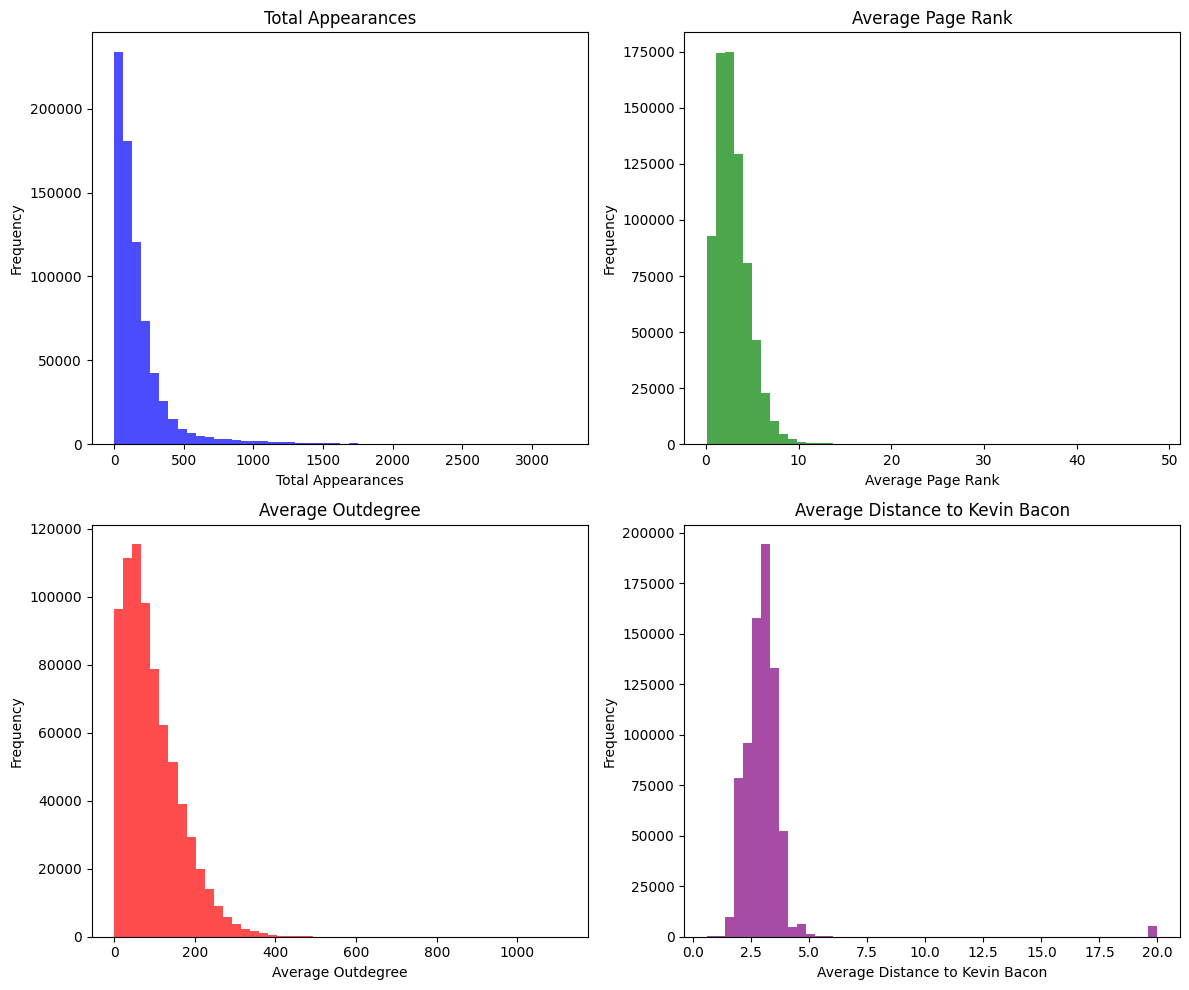

In [0]:
# Convert the features to a pandas DataFrame. We need to do this conversion to plot the distribution of the features as this is only supported by Pandas DataFrames and not by
# PySpark DataFrames 
data_pd = final_df.select("total_appearances", "avg_page_rank", "avg_outdegree", "avg_distance_to_kevin_bacon").toPandas()

# Plot histograms for each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for total_appearances
axes[0, 0].hist(data_pd['total_appearances'], bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Total Appearances')
axes[0, 0].set_xlabel('Total Appearances')
axes[0, 0].set_ylabel('Frequency')

# Histogram for avg_page_rank
axes[0, 1].hist(data_pd['avg_page_rank'], bins=50, color='green', alpha=0.7)
axes[0, 1].set_title('Average Page Rank')
axes[0, 1].set_xlabel('Average Page Rank')
axes[0, 1].set_ylabel('Frequency')

# Histogram for avg_outdegree
axes[1, 0].hist(data_pd['avg_outdegree'], bins=50, color='red', alpha=0.7)
axes[1, 0].set_title('Average Outdegree')
axes[1, 0].set_xlabel('Average Outdegree')
axes[1, 0].set_ylabel('Frequency')

# Histogram for avg_distance_to_kevin_bacon
axes[1, 1].hist(data_pd['avg_distance_to_kevin_bacon'], bins=50, color='purple', alpha=0.7)
axes[1, 1].set_title('Average Distance to Kevin Bacon')
axes[1, 1].set_xlabel('Average Distance to Kevin Bacon')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Note:**

**Since most of the Features clearly exhibit a non-normal distribution we decided to Normalize them in the Machine Learning Pipeline, by fitting a MinMaxScaler on the train data and transforming the train and test data to ensure Min=0 and Max=1 on every Feature, avoiding Data Leakage.**

### Machine Learning Pipeline

In [0]:
# Prepare the data for the Pipeline by creating feature vectors
feature_columns = ["total_appearances", "avg_page_rank", "avg_outdegree", "avg_distance_to_kevin_bacon"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Define the Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="rating")

# Create a Pipeline with the assembler, scaler, and linear regression stages
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing datasets
train_data, test_data = final_df.randomSplit([0.7, 0.3], seed=0)

# Fit the pipeline to the training data
pipeline_model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = pipeline_model.transform(test_data)

# Show some of the predictions
predictions.select("prediction", "rating", "scaled_features").show()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

+------------------+------+--------------------+
|        prediction|rating|     scaled_features|
+------------------+------+--------------------+
| 6.413405007712513|   4.9|[9.27643784786642...|
| 6.344008032791232|   6.6|[0.00618429189857...|
| 6.344827249691414|   5.2|[0.00587507730364...|
|  6.36039237079488|   6.1|[0.0,0.0181938866...|
| 6.366791369237754|   5.2|[0.0,0.0181938866...|
| 6.299852045017019|   6.5|[0.00432900432900...|
|  5.89266654440922|   6.4|[0.00989486703772...|
|  5.89266654440922|   6.4|[0.00989486703772...|
| 5.835235080870476|   7.1|[0.00989486703772...|
| 5.941405135450203|   6.1|[6.18429189857761...|
| 5.916789610815432|   6.1|[0.00123685837971...|
| 5.910787361248761|   7.2|[9.27643784786642...|
| 5.809243517718535|   5.4|[0.00618429189857...|
| 5.723646388136499|   5.9|[0.01360544217687...|
| 5.805122093955372|   6.4|[0.00247371675943...|
|5.8333608758051465|   5.7|[0.00278293135435...|
| 6.358753936994515|   7.1|[6.18429189857761...|
| 6.358753936994515|

In [0]:
# Print the coefficients and intercept for the Linear Regression
lr_model = pipeline_model.stages[-1]             # The last stage of the Pipeline is the linear regression model
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [-2.6493474551899867,-8.529995823255112,7.147681260690048,0.6700052717559231]
Intercept: 5.845580876017536


In [0]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 1.2267730763339295


**Q12** What score would your model predict for the 1997 movie Titanic.

In [0]:
# Step 1: Filter q2_df to get the tconst for "Titanic" with startYear 1997
titanic_tconst = q2_df.filter((col("primaryTitle") == "Titanic") & (col("startYear") == 1997)).select("tconst").collect()[0]["tconst"]

# Step 2: Use the tconst to get the corresponding row from final_df
titanic_features_row = final_df.filter(col("tconst") == titanic_tconst).collect()[0]

# Extract the features for prediction
sum_appearances = titanic_features_row["total_appearances"]
avg_page_rank = titanic_features_row["avg_page_rank"]
avg_outdegree = titanic_features_row["avg_outdegree"]
avg_distance_to_kevin_bacon = titanic_features_row["avg_distance_to_kevin_bacon"]

# Create a DataFrame with the feature values for "Titanic"
titanic_features = Row(total_appearances=sum_appearances, avg_page_rank=avg_page_rank, avg_outdegree=avg_outdegree, avg_distance_to_kevin_bacon=avg_distance_to_kevin_bacon)
titanic_df = spark.createDataFrame([titanic_features])

# Use the same pipeline as in Q11 to transform the features and make a prediction
titanic_transformed = pipeline_model.transform(titanic_df)

# Show the prediction
titanic_transformed.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|5.896977560846672|
+-----------------+



**Q13** Create dummy variables for each of the top 10 movie genres for Q10. These variable should have a value of 1 if the movie was rated with that genre and 0 otherwise. For example the 1997 movie Titanic should have a 1 in the dummy variable column for Romance, and a 1 in the dummy variable column for Drama, and 0's in all the other dummy variable columns.

Does adding these variable to the regression improve your results? What is the new RMSE and predicted rating for the 1997 movie Titanic.

In [0]:
# Step 1: Find the top 10 genres by number of votes
top_genres = q10_rdd.takeOrdered(10, key=lambda x: -x[1])

# Extract the top genres
top_genre_list = [genre for genre, _ in top_genres]

print(f'The 10 most popular genres by number of votes are {top_genre_list}')

The 10 most popular genres by number of votes are ['Drama', 'Action', 'Adventure', 'Comedy', 'Crime', 'Thriller', 'Sci-Fi', 'Romance', 'Mystery', 'Fantasy']


In [0]:
# Step 2: Create dummy variables for the top 10 genres
for genre in top_genre_list:
    q2_df = q2_df.withColumn(genre, when(col("genres").isNull(), 0).otherwise(when(array_contains(col("genres"), genre), 1).otherwise(0)))

# Display the DataFrame to verify the new columns
q2_df.show()

+---------+---------+--------+--------+----+--------------------+--------------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|   tconst|   nconst|ordering|category| job|          characters|         primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|Drama|Action|Adventure|Comedy|Crime|Thriller|Sci-Fi|Romance|Mystery|Fantasy|
+---------+---------+--------+--------+----+--------------------+--------------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+

In [0]:
# A reminder of how the train dataset looks like
train_data.show()

+---------+-----------------+-------------------+-------------+---------------------------+------+
|   tconst|total_appearances|      avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|
+---------+-----------------+-------------------+-------------+---------------------------+------+
|tt0022064|               76|  4.272723979659575|         98.0|                        2.0|   5.3|
|tt0024193|               21|  1.000000000000004|          1.0|                       20.0|   6.8|
|tt0025557|              105|  6.235885769190589|        156.0|                        3.0|   6.8|
|tt0026264|               22|  1.000000000000004|          1.0|                       20.0|   6.6|
|tt0026455|               21|  1.000000000000004|          1.0|                       20.0|   5.8|
|tt0027146|               21|  1.000000000000004|          1.0|                       20.0|   7.3|
|tt0027719|               21|  1.000000000000004|          1.0|                       20.0|   6.4|
|tt0029077

In [0]:
# A reminder of how the test dataset looks like
test_data.show()

+---------+-----------------+-------------------+-------------+---------------------------+------+
|   tconst|total_appearances|      avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|
+---------+-----------------+-------------------+-------------+---------------------------+------+
|tt0020652|                5| 0.6839284375000029|          1.0|                       20.0|   4.9|
|tt0026264|               22|  1.000000000000004|          1.0|                       20.0|   6.6|
|tt0027230|               21|  1.000000000000004|          1.0|                       20.0|   5.2|
|tt0034520|                2|  1.000000000000004|          1.0|                       20.0|   6.1|
|tt0034878|                2|  1.000000000000004|          2.0|                       20.0|   5.2|
|tt0036049|               16| 1.3160715625000057|          2.0|                       20.0|   6.5|
|tt0036606|               34| 1.3262397318985362|        36.75|                       2.25|   6.4|
|tt0036606

In [0]:
# Step 3: Join the train_data with q2_df to append the dummy variables
train_data_with_dummies = train_data.join(
    q2_df.select("tconst", "Drama", "Action", "Adventure", "Comedy", "Crime", "Thriller", "Sci-Fi", "Romance", "Mystery", "Fantasy"),
    on="tconst",
    how="left"
).fillna(0, subset=["Drama", "Action", "Adventure", "Comedy", "Crime", "Thriller", "Sci-Fi", "Romance", "Mystery", "Fantasy"])

# Step 4: Join the test_data with q2_df to append the dummy variables
test_data_with_dummies = test_data.join(
    q2_df.select("tconst", "Drama", "Action", "Adventure", "Comedy", "Crime", "Thriller", "Sci-Fi", "Romance", "Mystery", "Fantasy"),
    on="tconst",
    how="left"
).fillna(0, subset=["Drama", "Action", "Adventure", "Comedy", "Crime", "Thriller", "Sci-Fi", "Romance", "Mystery", "Fantasy"])

In [0]:
# Display the first few rows of the new train_data_with_dummies to verify
train_data_with_dummies.show(10)

+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|   tconst|total_appearances|     avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|Drama|Action|Adventure|Comedy|Crime|Thriller|Sci-Fi|Romance|Mystery|Fantasy|
+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|tt0022064|               76| 4.272723979659575|         98.0|                        2.0|   5.3|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0024193|               21| 1.000000000000004|          1.0|                       20.0|   6.8|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0025557|              105| 6.235885769190589|        156.0|                        3.0|   6.8|    1|     0|        0|     0|   

In [0]:
# Display the first few rows of the new test_data_with_dummies to verify
test_data_with_dummies.show(10)

+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|   tconst|total_appearances|     avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|Drama|Action|Adventure|Comedy|Crime|Thriller|Sci-Fi|Romance|Mystery|Fantasy|
+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|tt0020652|                5|0.6839284375000029|          1.0|                       20.0|   4.9|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0026264|               22| 1.000000000000004|          1.0|                       20.0|   6.6|    1|     0|        0|     0|    0|       0|     0|      1|      0|      0|
|tt0026264|               22| 1.000000000000004|          1.0|                       20.0|   6.6|    1|     0|        0|     0|   

In [0]:
# Prepare the data for the Pipeline by creating feature vectors for continuous and dummy features
feature_columns_with_dummies = feature_columns + ["Drama", "Action", "Adventure", "Comedy", "Crime", "Thriller", "Sci-Fi", "Romance", "Mystery", "Fantasy"]
assembler_all = VectorAssembler(inputCols=feature_columns_with_dummies, outputCol="features")

# Normalize the continuous features using MinMaxScaler
# NOTE: It makes no difference to include the dummy variables in the MinMaxScaler fitting because they will mathematically remain as 0 (genre not present) or 1 (genre present)
scaler_all = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Define the Linear Regression model
lr_all = LinearRegression(featuresCol="scaled_features", labelCol="rating")

# Create a Pipeline with the assembler, scaler, and linear regression stages
pipeline_all = Pipeline(stages=[assembler_all, scaler_all, lr_all])

# Fit the pipeline to the training data
pipeline_model_all = pipeline_all.fit(train_data_with_dummies)

# Make predictions on the test data
predictions_all = pipeline_model_all.transform(test_data_with_dummies)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
# Evaluate the model using RMSE
rmse_all = evaluator.evaluate(predictions_all)
print(f"RMSE for model with numerical and dummy variables: {rmse_all}")

RMSE for model with numerical and dummy variables: 1.1619980200481081


**The RMSE went from 1.2267730763339295 to 1.1619980200481081, which means that the inclusion of the dummy variables improves the results**

In [0]:
# Create a dictionary with the feature values for "Titanic" including dummy variables
# NOTE: The numerical variables for 1997 Titanic were already computed on Q12 and, since the dummy variables for this movie were already provided on this question, we assumed that we could use them without having to retrieve them from the DataFrame 
titanic_features_dict = {
    "total_appearances": sum_appearances,
    "avg_page_rank": avg_page_rank,
    "avg_outdegree": avg_outdegree,
    "avg_distance_to_kevin_bacon": avg_distance_to_kevin_bacon,
    "Drama": 1,
    "Action": 0,
    "Adventure": 0,
    "Comedy": 0,
    "Crime": 0,
    "Thriller": 0,
    "Sci-Fi": 0,
    "Romance": 1,
    "Mystery": 0,
    "Fantasy": 0
}

# Create a DataFrame with the feature values for "Titanic" including dummy variables
titanic_df = spark.createDataFrame([Row(**titanic_features_dict)])

# Predict the rating for Titanic (1997)
titanic_all_transformed = pipeline_model_all.transform(titanic_df)
titanic_all_prediction = titanic_all_transformed.select("prediction").collect()[0]["prediction"]
print(f"Predicted rating for Titanic (1997) with continuous and dummy features: {titanic_all_prediction}")

Predicted rating for Titanic (1997) with continuous and dummy features: 6.1714834425905964


**Q14 - Open Question**: Improve your model by testing different machine learning algorithms, using hyperparameter tuning on these algorithms, changing the included features. What is the RMSE of you final model and what rating does it predict for the 1997 movie Titanic.

In [0]:
# A reminder of how the train data with dummies looks like
train_data_with_dummies.show()

+---------+-----------------+-------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|   tconst|total_appearances|      avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|Drama|Action|Adventure|Comedy|Crime|Thriller|Sci-Fi|Romance|Mystery|Fantasy|
+---------+-----------------+-------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|tt0040483|                2|  1.000000000000004|          1.0|                       20.0|   4.8|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0040483|                2|  1.000000000000004|          1.0|                       20.0|   4.8|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0040695|               20| 2.0699210686705705|         12.0|                        3.0|   7.1|    0|     0|        0|    

In [0]:
# A reminder of how the train data looks like 
train_data.show()

+---------+-----------------+-------------------+-------------+---------------------------+------+
|   tconst|total_appearances|      avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|
+---------+-----------------+-------------------+-------------+---------------------------+------+
|tt0040483|                2|  1.000000000000004|          1.0|                       20.0|   4.8|
|tt0040695|               20| 2.0699210686705705|         12.0|                        3.0|   7.1|
|tt0043858|                8| 0.2036990212723558|          2.0|                        4.0|   4.9|
|tt0044770|               22|0.45060860974103306|          4.5|                        2.5|   6.3|
|tt0044770|               22|0.45060860974103306|          4.5|                        2.5|   6.3|
|tt0047313|               76|  4.272723979659575|         98.0|                        2.0|   7.3|
|tt0049309|               92| 2.3036259823208445|         40.0|                        3.0|   6.0|
|tt0049309

In [0]:
# A reminder of how the test data with dummies looks like
test_data_with_dummies.show()

+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|   tconst|total_appearances|     avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|Drama|Action|Adventure|Comedy|Crime|Thriller|Sci-Fi|Romance|Mystery|Fantasy|
+---------+-----------------+------------------+-------------+---------------------------+------+-----+------+---------+------+-----+--------+------+-------+-------+-------+
|tt0020652|                5|0.6839284375000029|          1.0|                       20.0|   4.9|    0|     0|        0|     0|    0|       0|     0|      0|      0|      0|
|tt0026264|               22| 1.000000000000004|          1.0|                       20.0|   6.6|    1|     0|        0|     0|    0|       0|     0|      1|      0|      0|
|tt0026264|               22| 1.000000000000004|          1.0|                       20.0|   6.6|    1|     0|        0|     0|   

In [0]:
# A reminder of how the test data looks like
test_data.show()

+---------+-----------------+-------------------+-------------+---------------------------+------+
|   tconst|total_appearances|      avg_page_rank|avg_outdegree|avg_distance_to_kevin_bacon|rating|
+---------+-----------------+-------------------+-------------+---------------------------+------+
|tt0020652|                5| 0.6839284375000029|          1.0|                       20.0|   4.9|
|tt0026264|               22|  1.000000000000004|          1.0|                       20.0|   6.6|
|tt0027230|               21|  1.000000000000004|          1.0|                       20.0|   5.2|
|tt0034520|                2|  1.000000000000004|          1.0|                       20.0|   6.1|
|tt0034878|                2|  1.000000000000004|          2.0|                       20.0|   5.2|
|tt0036049|               16| 1.3160715625000057|          2.0|                       20.0|   6.5|
|tt0036606|               34| 1.3262397318985362|        36.75|                       2.25|   6.4|
|tt0036606

**Note**:

To solve this question, firstly we aimed to compare the performance of Decision Tree and Random Forest models on predicting movie ratings using both continuous features and a combination of continuous and dummy variables. The models would be trained and evaluated using cross-validation to ensure robust performance metrics. Unfortunately, due to computational constraints and time limitations, we were unable to wait for the results to complete the evaluation and determine the best performing model for predicting the rating of the 1997 movie Titanic. 

To overcome these problems, we decided to train a Decision Tree model and fine-tune it using Cross-Validation, only using the dataset without the dummy variables (we also tried with the continuous and dummy variables but the time waiting was unfeasible).

In [0]:
# Define feature columns
continuous_features = ["total_appearances", "avg_page_rank", "avg_outdegree", "avg_distance_to_kevin_bacon"]

# Assemble continuous features
assembler_continuous = VectorAssembler(inputCols=continuous_features, outputCol="features")

# Prepare Decision Tree models
dt = DecisionTreeRegressor(featuresCol="features", labelCol="rating")

# Define pipelines for the Decision Tree models
pipeline_dt_cont = Pipeline(stages=[assembler_continuous, dt])

# Define parameter grids for hyperparameter tuning on the Decision Tree models
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3]).build()

# Define cross validators with 2 folds, due to time limitations and computational contraints (initially 5 folds were attempted) 
crossval_dt_cont = CrossValidator(estimator=pipeline_dt_cont,
                                  estimatorParamMaps=paramGrid_dt,
                                  evaluator=RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse"),
                                  numFolds=2)

print("Starting model training for Decision Tree with continuous features...")

# Train models using cross-validation
cv_model_dt_cont = crossval_dt_cont.fit(train_data)

print("Model training completed for Decision Tree with continuous features.")
print("Starting model evaluation...")

# Evaluate the best model, coming out of the hyperparameter tunning
predictions_dt_cont = cv_model_dt_cont.transform(test_data)

evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse_dt_cont = evaluator.evaluate(predictions_dt_cont)

In [0]:
print(f"RMSE for Decision Tree (continuous features): {rmse_dt_cont}")

RMSE for Decision Tree (continuous features): 1.2286817904146263


In [0]:
# Define the Titanic features
titanic_features_dict = {
    "total_appearances": sum_appearances,  
    "avg_page_rank": avg_page_rank,    
    "avg_outdegree": avg_outdegree,     
    "avg_distance_to_kevin_bacon": avg_distance_to_kevin_bacon,  
}

# Create a DataFrame with the feature values for "Titanic"
titanic_df = spark.createDataFrame([Row(**titanic_features_dict)])

# Transform the Titanic features using the best model pipeline
titanic_transformed = cv_model_dt_cont.transform(titanic_df)

# Collect and print the prediction
titanic_prediction = titanic_transformed.select("prediction").collect()[0]["prediction"]
print(f"Predicted rating for Titanic (1997) with the best model: {titanic_prediction}")

Predicted rating for Titanic (1997) with the best model: 6.187493231778023
